In [75]:
import pandas as pd
import numpy as np 

from gensim import corpora
from gensim.models import LsiModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.matutils import corpus2dense, corpus2csc, Sparse2Corpus

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.lda_model

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import joblib

import warnings
warnings.filterwarnings('ignore')


In [4]:
data = pd.read_csv("data/preprocessed.csv")
data_spotify = pd.read_csv("data/preprocessed_spotify.csv")
X = data['clean_lyrics'].apply(str.split)

## Latent Dirichlet Allocation

In [96]:
# Define helper function to print and return top words
def get_topic_words(lda_model, feature_names, n_words=10, print_words= False):
    topic_words = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        # words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        # topic_words[f"Topic {topic_idx}"] = words

         # Get words and their weights
        word_weights = {feature_names[i]: topic[i] for i in range(len(feature_names))}
        # Sort words by their weights in descending order
        sorted_words = dict(sorted(word_weights.items(), key=lambda item: item[1], reverse=True))
        # topic_words[f"Topic {topic_idx}"] = sorted_words
        topic_words[topic_idx] = sorted_words

        # print if needed
        if print_words:
            message = "Topic # {}: ".format(topic_idx)
            message += " ;".join([feature_names[i] for i in topic.argsort()[:-n_words - 1 :-1]])
            print(message)

    return topic_words

# Define a function to compute coherence score using gensim
def compute_coherence_score(lda_model, corpus, dictionary, feature_names):
    topics = []
    for topic_id in range(lda_model.n_components):
        topic_words = [feature_names[i] for i in np.argsort(lda_model.components_[topic_id])[::-1]]
        topics.append(topic_words)
    
    coherence_model = CoherenceModel(topics=topics, texts=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [6]:
tfidf = TfidfVectorizer(min_df= 0.01, max_df= 0.6, ngram_range= (1,4))
X = tfidf.fit_transform(data_spotify['clean_lyrics'])
feature_names = tfidf.get_feature_names_out()

# Create a dictionary and a corpus
corpus = [text.split() for text in data_spotify['clean_lyrics']]
dictionary = Dictionary(corpus)

In [58]:
coherences = []
perplexities = []

from tqdm import tqdm
for nn in tqdm(range(2,22,2)):
    lda = LatentDirichletAllocation(n_components= nn, random_state= 0)
    lda.fit_transform(X)
    perplexities.append(lda.perplexity(X))
    coherences.append(compute_coherence_score(lda, corpus, dictionary, feature_names))
    

100%|██████████| 10/10 [1:03:44<00:00, 382.49s/it]


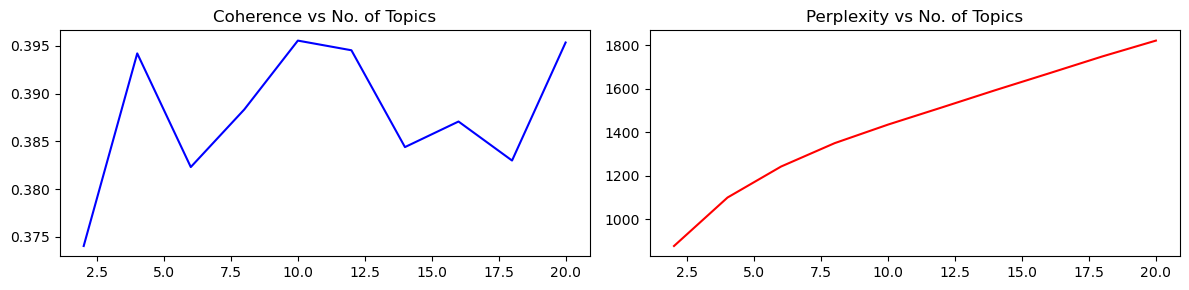

In [59]:
fig,axs = plt.subplots(figsize= (12,3), ncols= 2)
axs[0].plot(range(2,22,2), coherences, color= "blue")
axs[0].set_title("Coherence vs No. of Topics", fontsize= 12)

axs[1].plot(range(2,22,2), perplexities, color= "red")
axs[1].set_title("Perplexity vs No. of Topics", fontsize= 12)

plt.tight_layout();
fig.savefig("images/perplexity_coherence.png")

Topic # 0: god ;lord ;jesus ;life ;king ;love ;praise ;world ;holy ;come
Topic # 1: dance ;song ;music ;sing ;play ;like ;everybody ;happy ;love ;get
Topic # 2: love ;heart ;never ;know ;ill ;im ;one ;time ;say ;love love
Topic # 3: hey ;fire ;im ;hey hey ;burn ;like ;love ;blood ;take ;feel
Topic # 4: go ;home ;im ;back ;going ;road ;get ;time ;town ;come
Topic # 5: christmas ;love ;day ;dream ;sky ;sun ;away ;like ;night ;blue
Topic # 6: wa ;said ;man ;like ;one ;well ;never ;day ;night ;old
Topic # 7: got ;ta ;got ta ;ive ;get ;im ;aint ;ive got ;rock ;good
Topic # 8: im ;get ;got ;like ;nigga ;ya ;aint ;shit ;know ;man
Topic # 9: na ;gon na ;gon ;wan ;wan na ;im gon na ;im gon ;im ;get ;na get
Topic # 10: im ;know ;cant ;time ;see ;say ;way ;away ;like ;love
Topic # 11: baby ;love ;want ;know ;im ;let ;girl ;feel ;got ;like


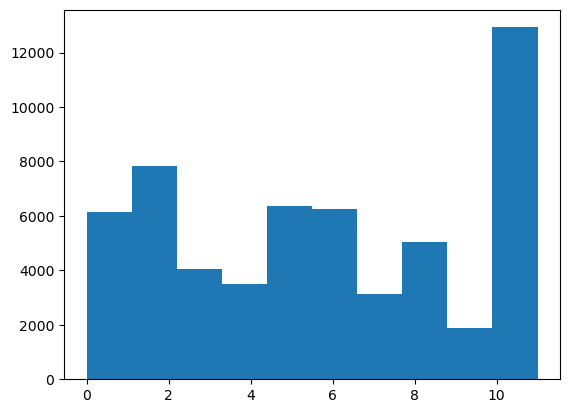

In [97]:
# lda = LatentDirichletAllocation(n_components= 12, random_state= 22, max_iter= 20)
# doc_topic = lda.fit_transform(X)


plt.hist(np.argmax(doc_topic, axis= 1)); 
topic_words = get_topic_words(lda, feature_names, n_words= 10, print_words= True);
topic_words = get_topic_words(lda, feature_names, print_words= False);

In [98]:
# label topics. hard code for now.
topic_name_map = {0: "biblical", 1: "music_dance", 2: "forever_love", 3: "darkness_fire_death",
                  4: "going_home", 5: "christmas_dream", 6: "time_and_life", 7: "ive_got_to",
                  8: "generic_rap", 9: "baby_im_gonna", 10: "confusion", 11: "feeling_love"}

# # print most common n-grams for each topic to get the topic name
# lda_topic = pd.DataFrame(doc_topic).idxmax(axis= 1)

# tfidf_ngram = TfidfVectorizer(ngram_range= (3,5), min_df= 0.0005, max_df= 0.4)
# dt_ngram = tfidf_ngram.fit_transform(data_spotify['clean_lyrics'])
# ngram_names = tfidf_ngram.get_feature_names_out()

# for tt in range(0, lda.n_components):
#     print_str = "Topic " + str(tt) + ": "
#     print_str = print_str + "; ".join(pd.DataFrame(tfidf_ngram.transform(data_spotify.loc[lda_topic == tt, 'clean_lyrics']).
#               mean(axis=0).A1, index= ngram_names, columns= [tt]).sort_values(tt, ascending= False).head(10).index.tolist()) 
#     print(print_str)

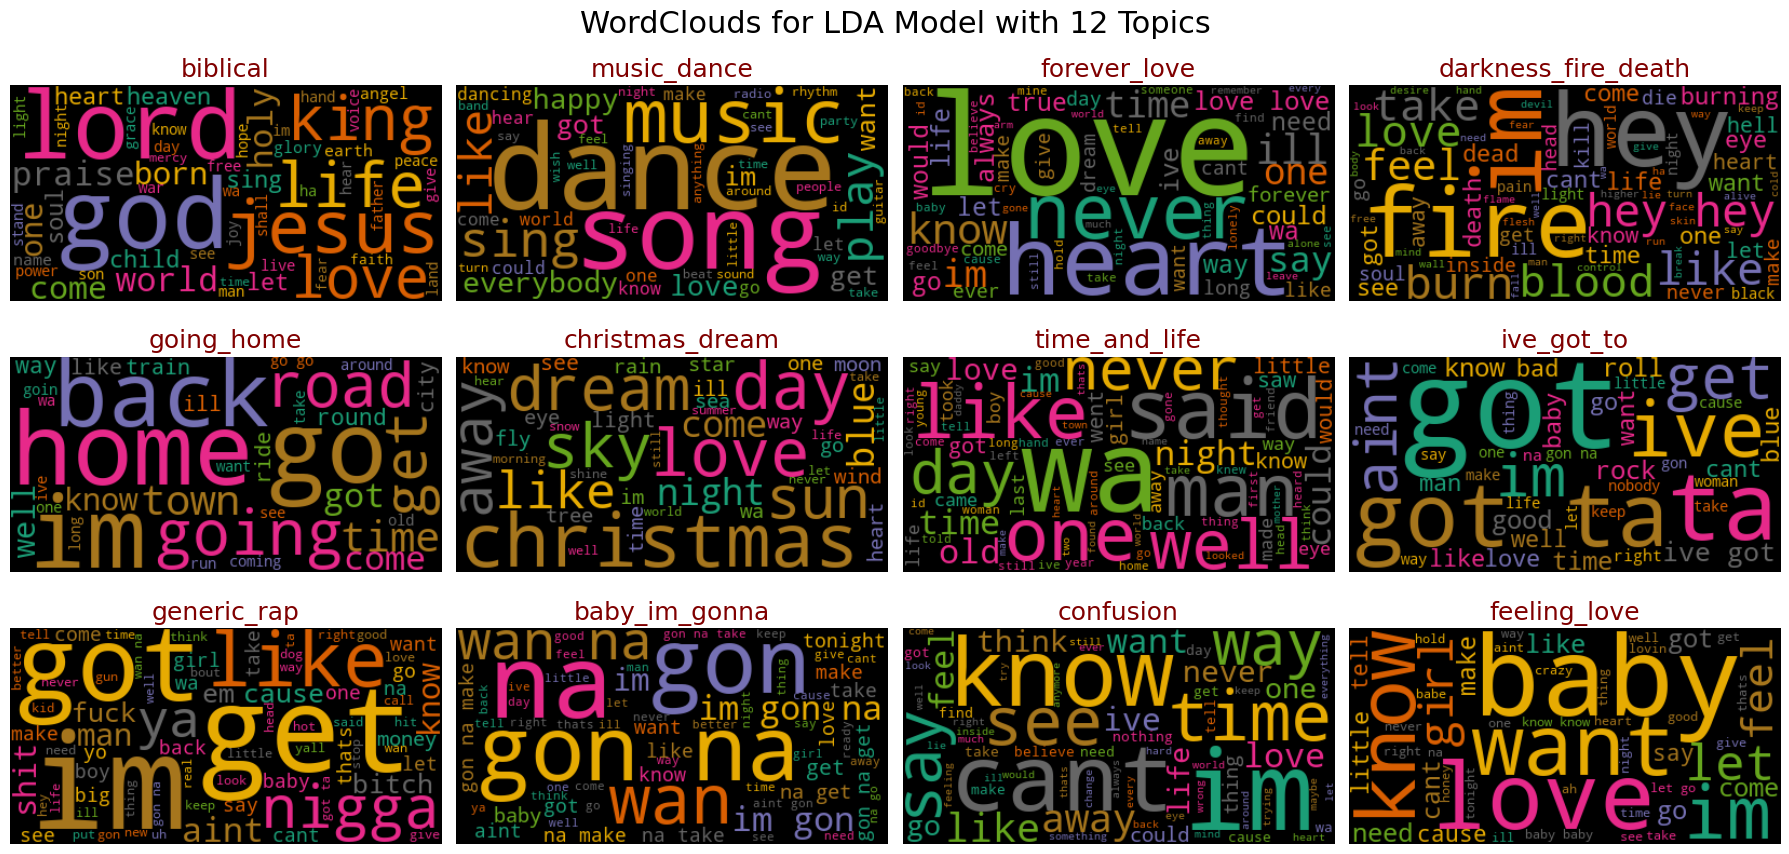

In [99]:
fig,axs = plt.subplots(figsize= (18,9), ncols= 4, nrows= int(np.ceil(lda.n_components/4)) )


def plot_wordcloud(words, title, ax):
    wordcloud = WordCloud(background_color='black', contour_color='steelblue', contour_width=1,
                          colormap='Dark2_r', min_font_size= 10).generate_from_frequencies(words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize= 18, color= "maroon")
    ax.axis('off')

ii = 0; jj = 0
# Turn off the axis for each subplot
for ax in axs.flatten():
    ax.axis('off')

for topic, words in topic_words.items():
    plot_wordcloud(words, topic_name_map[topic], axs[ii][jj])
    if jj == 3:
        jj = 0
        ii += 1
    else:
        jj += 1

plt.suptitle("WordClouds for LDA Model with 12 Topics", fontsize= 22)
plt.tight_layout();
fig.savefig("images/lda_wordclous_12_topics.png")


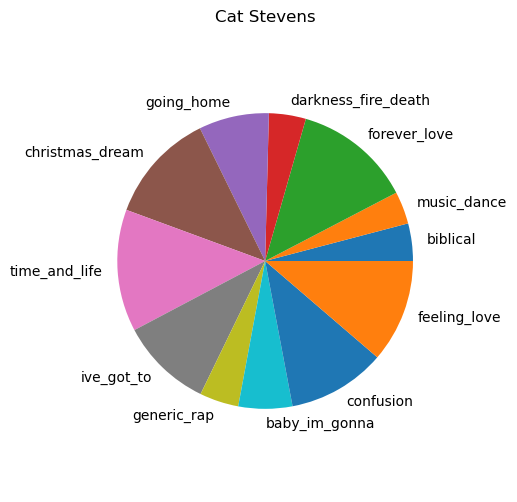

In [138]:
artist = "Cat Stevens"

test_dt = data_spotify.query(f"artist=='{artist}'")
results_dt = pd.DataFrame(lda.transform(tfidf.transform(test_dt['clean_lyrics'])), index= test_dt['song'])
results_dt.rename(columns= topic_name_map, inplace= True)

plt.figure(figsize= (6,6))
plt.pie(results_dt.sum(), labels= results_dt.columns, radius= 0.8);
plt.title(artist);

In [139]:
results_dt = pd.DataFrame(lda.transform(tfidf.transform(data['clean_lyrics'])), index= data.index)
results_dt.rename(columns= topic_name_map, inplace= True)

data = data.merge(results_dt, left_index= True, right_index= True)

In [150]:
data.dropna().to_csv("results/Billboard_songs_labeled.csv", index= None)

In [76]:
joblib.dump(lda, 'lda_model.pkl')
joblib.dump(tfidf, 'tfidf.pkl')

# # Prepare LDAvis visualization
# lda_vis = pyLDAvis.lda_model.prepare(lda, X, tfidf)
# pyLDAvis.show(lda_vis, local= False)

['tfidf.pkl']

In [137]:
data_spotify[data_spotify.artist.str.lower().str.contains('cat')]

,artist,song,text,lang,clean_lyrics
2224,Cat Stevens,a bad penny,Oh don't say those same idle lies \r\nI've he...,en,say idle lie ive heard fool left heart early t...
2225,Cat Stevens,angelsea,She moves like and angel \r\nAnd seven evenin...,en,move like angel seven evening star dance windo...
2226,Cat Stevens,another saturday night,[Chorus: ] \r\nAnother Saturday night and I a...,en,another saturday night aint got nobody ive got...
2227,Cat Stevens,bitterblue,I gave my last chance to you \r\nDon't hand i...,en,gave last chance hand back bitterblue bitterbl...
2228,Cat Stevens,but i might die tonight,I don't want to work away \r\nDoing just what...,en,want work away say work hard boy find one day ...
...,...,...,...,...,...
26755,Cat Stevens,tuesdays dead,"If I make a mark in time, I can't say the mark...",en,make mark time cant say mark mine im underline...
26756,Cat Stevens,when i speak to the flowers,When I speak to the flowers in my backyard \r...,en,speak flower backyard speak flower backyard sp...
26757,Cat Stevens,where are you,I know I think a lot \r\nBut somehow it just ...,en,know think lot somehow help make worse think k...
26758,Cat Stevens,where do the children play,"Well I think it's fine, building jumbo planes....",en,well think fine building jumbo plane takin rid...


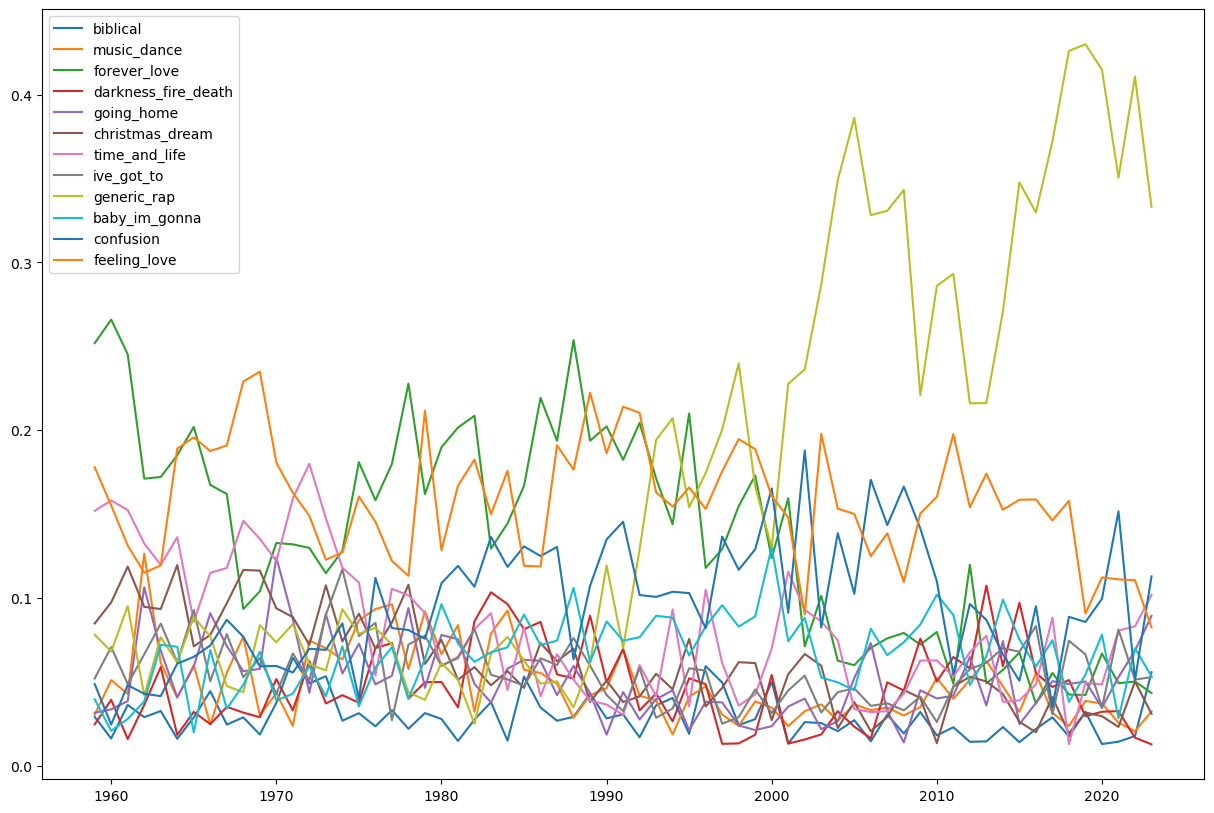

In [168]:
plt.figure(figsize= (15,10))
plt.plot(data.groupby('Year')[results_dt.columns].agg(lambda x: x.sum()/len(x)));
plt.legend(results_dt.columns);

In [169]:
data[data.darkness_fire_death > 0.1]

,Album,Artist,Featured Artists,Lyrics,Rank,Release Date,Song Title,Writers,Year,lang,...,forever_love,darkness_fire_death,going_home,christmas_dream,time_and_life,ive_got_to,generic_rap,baby_im_gonna,confusion,feeling_love
13,The Great Pretender,Platters,[],They asked me how I knew My true love was true...,16,NaN,smoke gets in your eyes,"['otto harbach', 'jerome kern']",1959.0,en,...,0.480728,0.373416,0.014585,0.014586,0.014586,0.014585,0.014586,0.014585,0.014586,0.014585
49,Turn Me Loose... The Very Best of Fabian,Fabian,[],"Turn me loose, turn me loose I say This is the...",55,NaN,turn me loose,[''],1959.0,en,...,0.020460,0.451302,0.020460,0.020460,0.020461,0.020461,0.020460,0.344095,0.020460,0.020460
128,NaN,Fendermen,[],"Well, good morning, Captain Well, good morning...",44,NaN,mule skinner blues,[''],1960.0,en,...,0.022412,0.753461,0.022413,0.022412,0.022413,0.022413,0.022413,0.022412,0.022412,0.022412
133,Cruisin’ 1960,Hank Ballard and The Midnighters,[],"(Hey now, hey now, hey now, hey now) (It's fin...",49,NaN,finger poppin time,[''],1960.0,en,...,0.019237,0.788385,0.019237,0.019237,0.019237,0.019238,0.019243,0.019237,0.019237,0.019239
142,Bobby Vee,Bobby Vee,[],"Devil or angel, I can't make up my mind Which ...",59,NaN,devil or angel,[''],1960.0,en,...,0.644083,0.174647,0.018127,0.018127,0.018127,0.018127,0.018127,0.018127,0.018127,0.018127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5283,GIRL,Maren Morris,[],We're in the homestretch of the hard times We ...,9,2019-02-22,the bones,"['maren morris', 'laura veltz', 'jimmy robbins']",2020.0,en,...,0.013730,0.848960,0.013730,0.013730,0.013730,0.013730,0.013730,0.013731,0.013730,0.013738
5364,Dreamland,Glass Animals,[],"(Last night, all I think about is you) (Don't ...",16,2020-06-29,heat waves,['dave bayley'],2021.0,en,...,0.014673,0.838597,0.014674,0.014672,0.014673,0.014674,0.014674,0.014673,0.014672,0.014674
5416,Dawn FM (Alternate World),The Weeknd,[],"Yeah, yeah, yeah [Verse 1] I saw the fire in ...",89,2021-08-06,take my breath,"['oscar holter', 'belly', 'max martin', 'the w...",2021.0,en,...,0.014248,0.357018,0.014248,0.014248,0.014248,0.014248,0.014248,0.014248,0.014248,0.500503
5418,Soul,Eric Church,[],"I was no daddy's dream, was not your mama's pr...",91,2020-10-02,hell of a view,"['monty criswell', 'casey beathard', 'eric chu...",2021.0,en,...,0.013417,0.328465,0.013417,0.013417,0.013417,0.537367,0.013417,0.013417,0.013417,0.013417


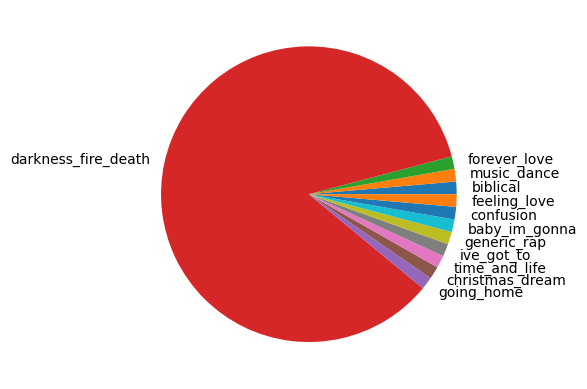

In [182]:
plt.pie(data.loc[data['Song Title'] == 'the bones', results_dt.columns].values[0],
        labels= results_dt.columns);